In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from tqdm.notebook import tqdm
import os
from pathlib import Path

import torch
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [251]:
PYTHON_PATHS = ["../.."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        

from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
from imap.data.datasets.tum.tum_dataset_loader_factory import TUMDatasetLoaderFactory
from imap.model.nerf import NERF
from imap.model.embeddings.gaussian_positional_encoding import GaussianPositionalEncoding
from imap.model.embeddings.gaussian_positional_embedding import GaussianPositionalEmbedding
from imap.trainers.trainers import ModelTrainer
from imap.model.active_sampling.image_active_sampling import ImageActiveSampling
from imap.utils.utils import *

In [252]:
image_width = 640
image_height = 480
points_per_image = int(200)
num_epochs = 300
is_image_active_sampling = True



def train_model(model, dataset_loader, camera, trainer, num_epochs, is_image_active_sampling, verbose_step=5):
    for i in tqdm(range(num_epochs)):
        # train the model
        for color_image, depth_image, position in dataset_loader:
            state = camera.create_state(color_image, depth_image, position)
            loss = trainer.train(model, state, is_image_active_sampling)
            load_last_state = True

        # trainer.reset_params()

        if i%verbose_step == 0:
            print(f"loss {torch.mean(loss['loss']).item()}")
        # clear_output(wait=True)

    torch.cuda.empty_cache()

def render_images(model, camera, dataset_loader, image_height=image_height, image_width=image_width):
    # prepare image coordinates

    scale = 1
    height = image_height
    width = image_width
    x, y = generate_image_meshgrid(width, height, scale)
    np_pixels = get_ji_pixels_from_meshgrid(x, y, scale)


    # positions for rendering
    # TODO: manually generate positions
    positions = []
    for _, _, position in dataset_loader:
        positions.append(camera.process_positions(position))


    # reder the image

    batch_size = 4096

    model = model.cuda()
    model.eval()


    pixels = torch.from_numpy(np_pixels.copy()).cuda()

    color_coarse_images = []
    depth_coarse_images =[]
    color_fine_images = []
    depth_fine_images = []

    mean = camera._color_mean
    std = camera._color_std

    with torch.no_grad():
        for pos in positions:
            position = torch.from_numpy(pos).to('cuda')
            output_coarse_color = []
            output_coarse_depth = []
            output_fine_color = []
            output_fine_depth = []

            for i in tqdm(range(int(np.ceil(pixels.shape[0] / batch_size)))):
                output = model(pixels[i * batch_size : i * batch_size + batch_size],
                                     position)
                output_coarse_color.append(output[0])
                output_coarse_depth.append(output[1])
                output_fine_color.append(output[2])
                output_fine_depth.append(output[3])

            reconstructed_image = reshape_points_list_to_image(output_coarse_color,height, width, scale).detach().cpu().numpy()
            reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
            reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
            color_coarse_images.append(reconstructed_image)

            reconstructed_image = reshape_points_list_to_image(output_fine_color,height, width, scale).detach().cpu().numpy()
            reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
            reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
            color_fine_images.append(reconstructed_image)

            reconstructed_depth = torch.cat(output_coarse_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
            depth_coarse_images.append(reconstructed_depth)


            reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
            depth_fine_images.append(reconstructed_depth)

    del output_coarse_color, output_coarse_depth, output_fine_color, output_fine_depth, position, pixels
    torch.cuda.empty_cache()
    return color_coarse_images, depth_coarse_images, color_fine_images, depth_fine_images

In [253]:
import plotly.graph_objects as go
def show_trajectories(shown_truth_trajectory, shown_predicted_trajectory):
    fig = go.Figure(
        data=[
            go.Scatter3d(x=shown_truth_trajectory[:, 0],
                         y=shown_truth_trajectory[:, 1], 
                         z=shown_truth_trajectory[:, 2],
                         mode="markers",
                         name="truth",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=shown_predicted_trajectory[:, 0],
                         y=shown_predicted_trajectory[:, 1],
                         z=shown_predicted_trajectory[:, 2],
                         mode="markers",
                         name="predicted",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=make_lines(shown_truth_trajectory[:, 0], shown_predicted_trajectory[:, 0]),
                         y=make_lines(shown_truth_trajectory[:, 1], shown_predicted_trajectory[:, 1]),
                         z=make_lines(shown_truth_trajectory[:, 2], shown_predicted_trajectory[:, 2]),
                         mode="lines",
                         name="errors")
        ]
    )
    fig.update_layout(height=1280,width=960)
    fig.show()
    
    



def make_lines(markers1, markers2):
    result = []
    for x1, x2 in zip(markers1, markers2):
        result.append(x1)
        result.append(x2)
        result.append(None)
    return result

def make_matrix_44_from_34(matrix):
    result = np.zeros((matrix.shape[0], 4, 4))
    result[:, 3, 3] = 1
    result[:, :3, :] = matrix
    return result

# Track a few images

### Train on 1 image

In [189]:
len([*range(0,100,5)])

20

In [288]:

dataset_params = {'dataset_path': "/home/quetalasj/datasets/TUM RGBD/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [*range(0,100,5)],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading /home/quetalasj/datasets/TUM RGBD/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [289]:
model_parameters = AttributeDict(
    name="NERF",
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    minimal_depth=0.01,
    positional_embedding = AttributeDict(
                                        name = 'GaussianPositionalEmbedding',
                                        encoding_dimension=93,
                                        sigma=25,
                                        use_only_sin=False,
                                        use_bias=True
                                        )
)

factory = UniversalFactory([NERF, GaussianPositionalEncoding, GaussianPositionalEmbedding])
model = factory.make_from_parameters(model_parameters, camera_info=camera)

In [290]:
model.cuda()
model.train()

image_active_sampler = ImageActiveSampling(image_width, image_height, points_per_image)
trainer = ModelTrainer(model.parameters(), image_active_sampler, lr=0.005)

train_model(model, dataset_loader, camera, trainer, 300, is_image_active_sampling=True)

  0%|          | 0/300 [00:00<?, ?it/s]

loss 1.5492489337921143
loss 1.5690144300460815
loss 1.3850584030151367
loss 1.7080762386322021
loss 1.3855712413787842
loss 1.4241613149642944
loss 1.3779284954071045
loss 1.3038421869277954
loss 1.3471417427062988
loss 1.252337098121643
loss 1.244698405265808
loss 1.1314786672592163
loss 1.3722403049468994
loss 1.4109792709350586
loss 1.12531578540802
loss 1.283646821975708
loss 1.0888396501541138
loss 1.052746295928955
loss 1.1873043775558472
loss 1.265400767326355
loss 1.4388494491577148
loss 1.3350505828857422
loss 1.2399481534957886
loss 1.0718705654144287
loss 1.0929522514343262
loss 1.2070410251617432
loss 1.1289024353027344
loss 1.0913164615631104
loss 1.1335780620574951
loss 1.058085322380066
loss 1.091104507446289
loss 1.0832000970840454
loss 1.1575556993484497
loss 1.0373896360397339
loss 1.2898494005203247
loss 1.0103168487548828
loss 1.1067746877670288
loss 1.207861304283142
loss 0.8765328526496887
loss 1.0622230768203735
loss 1.103649377822876
loss 0.916753351688385
loss

In [291]:
model.eval()
color_coarse_images, depth_coarse_images, color_fine_images, depth_fine_images = render_images(model, camera, dataset_loader)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

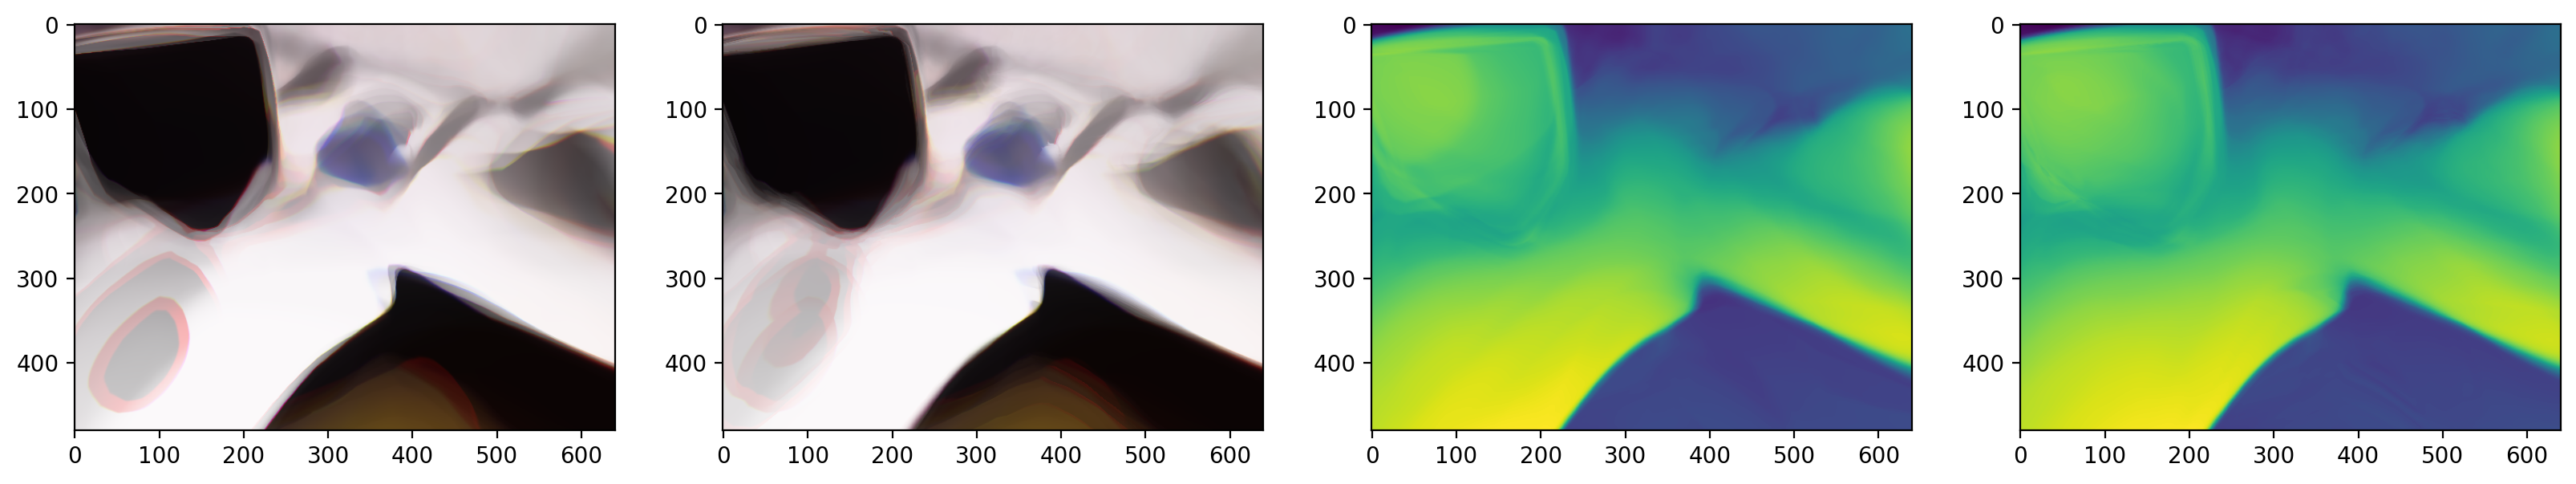

In [306]:
indx = 0
figure = plt.figure(dpi=200, figsize=(20,18))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(color_coarse_images[indx], cv2.COLOR_RGB2BGR))


plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(color_fine_images[indx], cv2.COLOR_RGB2BGR))

plt.subplot(1,4,3)
plt.imshow(1. /depth_coarse_images[indx])


plt.subplot(1,4,4)
plt.imshow(1. /depth_fine_images[indx])

### Tracking

In [307]:
dataset_params = {'dataset_path': "/home/quetalasj/datasets/TUM RGBD/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [*range(100)],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, tracking_dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading /home/quetalasj/datasets/TUM RGBD/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [308]:
poses = []
num_epochs = 100

model.cuda()
model.eval()
model.requires_grad_(False)

is_image_active_sampling = False

is_initialization = True

for color_image, depth_image, p in tracking_dataset_loader:
    if is_initialization:
        current_position = p
        process_position = True
    print(current_position)
    
    state = camera.create_state(color_image, depth_image, current_position, process_position)
    process_position = False
    state.train_position()
    state._position.cuda()
    if is_initialization:
        is_initipositionalization = False
        trainer = ModelTrainer([state._position], image_active_sampler, lr=0.0001)
    else:
        trainer.optimizer.add_param_group({'params':state._position})
    trainer.reset_params()
    # trainer.optimizer.param_groups.clear()
    # trainer.optimizer.state.clear()
    
    
    for i in tqdm(range(num_epochs)):
        loss = trainer.train(model, state, is_image_active_sampling)
        if i%20 == 0:
            print(f"loss {torch.mean(loss['loss']).item()}")
    print("-"*10)
    
    
    state.freeze_position()
    state._position.cpu()
    
    current_position = state.get_matrix_position().detach().numpy()
    poses.append(current_position.copy())

    # trainer.reset_params()

torch.cuda.empty_cache()

[[ 0.8722986   0.4882979   0.02569568  0.        ]
 [ 0.34789497 -0.58283824 -0.73434913  0.        ]
 [-0.34360474  0.64951116 -0.67828536  0.        ]
 [ 1.3112      0.8507      1.5186      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5337344408035278
loss 0.5645906925201416
loss 0.49138182401657104
loss 0.5666407942771912
loss 0.4686315953731537
----------
[[ 0.882051    0.47078338  0.01868358  0.        ]
 [ 0.33039793 -0.5897835  -0.73688036  0.        ]
 [-0.33589175  0.6561391  -0.6757649   0.        ]
 [ 1.319       0.8446      1.5203      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5912477970123291
loss 0.447370707988739
loss 0.488386332988739
loss 0.4580521285533905
loss 0.5182846784591675
----------
[[ 0.8895647   0.45666516  0.01147141  0.        ]
 [ 0.31486657 -0.5947665  -0.7396701   0.        ]
 [-0.33095875  0.66159636 -0.6728718   0.        ]
 [ 1.3263      0.8375      1.5226      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5307146310806274
loss 0.5025781989097595
loss 0.6651121377944946
loss 0.5081276297569275
loss 0.5265790820121765
----------
[[ 0.90135014  0.43305656  0.00547231  0.        ]
 [ 0.29153025 -0.59734076 -0.7471239   0.        ]
 [-0.32027808  0.67501557 -0.6646623   0.        ]
 [ 1.337       0.8274      1.5265      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5497069358825684
loss 0.46446260809898376
loss 0.5358548760414124
loss 0.4866108298301697
loss 0.49129050970077515
----------
[[ 9.0989208e-01  4.1484505e-01 -7.4236355e-05  0.0000000e+00]
 [ 2.7326912e-01 -5.9950399e-01 -7.5227582e-01  0.0000000e+00]
 [-3.1212243e-01  6.8446952e-01 -6.5884829e-01  0.0000000e+00]
 [ 1.3454000e+00  8.1900001e-01  1.5298001e+00  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5057653784751892
loss 0.49496299028396606
loss 0.5254281163215637
loss 0.5750716924667358
loss 0.49942851066589355
----------
[[ 0.9156302   0.40197667 -0.00600622  0.        ]
 [ 0.25637877 -0.59536195 -0.76145524  0.        ]
 [-0.30966312  0.69567156 -0.64818966  0.        ]
 [ 1.3531      0.8097      1.5335      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5746306777000427
loss 0.49114349484443665
loss 0.562893807888031
loss 0.5170576572418213
loss 0.553011417388916
----------
[[ 0.92109686  0.38905048 -0.01484181  0.        ]
 [ 0.23607169 -0.5884134  -0.77333033  0.        ]
 [-0.30959767  0.7088084  -0.63382953  0.        ]
 [ 1.3627      0.7957      1.5391      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6966269016265869
loss 0.43900319933891296
loss 0.45755308866500854
loss 0.5132859945297241
loss 0.5088854432106018
----------
[[ 0.92403585  0.38186926 -0.01826601  0.        ]
 [ 0.22616045 -0.5845287  -0.77921605  0.        ]
 [-0.30823568  0.71589255 -0.62648916  0.        ]
 [ 1.3693      0.7843      1.5435      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5932033658027649
loss 0.5913026928901672
loss 0.528649628162384
loss 0.5107486248016357
loss 0.5112935304641724
----------
[[ 0.9243762   0.38072962 -0.02394947  0.        ]
 [ 0.21497332 -0.57174087 -0.79176944  0.        ]
 [-0.31514296  0.72674435 -0.6103504   0.        ]
 [ 1.3762      0.768       1.5488      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5674715042114258
loss 0.5427055358886719
loss 0.5006239414215088
loss 0.4643079936504364
loss 0.539679765701294
----------
[[ 0.92074156  0.38933498 -0.02555916  0.        ]
 [ 0.21544497 -0.5619363  -0.7986307   0.        ]
 [-0.3252975   0.7298259  -0.60127836  0.        ]
 [ 1.38        0.7538      1.5526      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5425448417663574
loss 0.5280541777610779
loss 0.4997836947441101
loss 0.49794667959213257
loss 0.5143964886665344
----------
[[ 0.9161401   0.39996573 -0.02673492  0.        ]
 [ 0.21776177 -0.5525698  -0.80451626  0.        ]
 [-0.33655185  0.73122776 -0.5933286   0.        ]
 [ 1.383       0.739       1.5562      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5338606238365173
loss 0.49232345819473267
loss 0.47117865085601807
loss 0.46801260113716125
loss 0.474845290184021
----------
[[ 0.9075399   0.41916603 -0.02590623  0.        ]
 [ 0.22482926 -0.5370297  -0.8130504   0.        ]
 [-0.3547155   0.7320512  -0.5816167   0.        ]
 [ 1.385       0.7191      1.5602      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5859193205833435
loss 0.5681775808334351
loss 0.5422937870025635
loss 0.4721834063529968
loss 0.523341715335846
----------
[[ 0.8976771   0.43996167 -0.0246887   0.        ]
 [ 0.23563968 -0.52662265 -0.81678796  0.        ]
 [-0.372357    0.7273942  -0.5764095   0.        ]
 [ 1.3859      0.7035      1.5632      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.45852479338645935
loss 0.5359423160552979
loss 0.47116565704345703
loss 0.5403546094894409
loss 0.5019867420196533
----------
[[ 0.88884103  0.45759246 -0.02389127  0.        ]
 [ 0.24255644 -0.5141035  -0.8227174   0.        ]
 [-0.38875186  0.72547    -0.5679483   0.        ]
 [ 1.3858      0.6887      1.566       1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6334072947502136
loss 0.6143060922622681
loss 0.5313006043434143
loss 0.5696319937705994
loss 0.5209276080131531
----------
[[ 0.87692237  0.48006663 -0.02330555  0.        ]
 [ 0.25278068 -0.5019022  -0.8271615   0.        ]
 [-0.40878972  0.71946526 -0.5614808   0.        ]
 [ 1.3841      0.6691      1.5694      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5809365510940552
loss 0.49973875284194946
loss 0.5351854562759399
loss 0.490741491317749
loss 0.48642364144325256
----------
[[ 0.8630815   0.50428456 -0.02805993  0.        ]
 [ 0.26291758 -0.49602973 -0.82754385  0.        ]
 [-0.43123615  0.70686036 -0.5606994   0.        ]
 [ 1.3814      0.6549      1.5717      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4982941448688507
loss 0.5229925513267517
loss 0.5774936079978943
loss 0.5470033288002014
loss 0.494717001914978
----------
[[ 0.8468829   0.5305008  -0.03685416  0.        ]
 [ 0.2723778  -0.49225345 -0.8267387   0.        ]
 [-0.45672715  0.6901126  -0.5613777   0.        ]
 [ 1.3781      0.6416      1.5737      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5353542566299438
loss 0.495930016040802
loss 0.5709642767906189
loss 0.39287474751472473
loss 0.5391841530799866
----------
[[ 0.82386947  0.5639172  -0.0568902   0.        ]
 [ 0.28144202 -0.4941624  -0.8225533   0.        ]
 [-0.49196497  0.6616652  -0.5658353   0.        ]
 [ 1.372       0.6246      1.5762      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.606852650642395
loss 0.5570868253707886
loss 0.5023079514503479
loss 0.5217292904853821
loss 0.4550522565841675
----------
[[ 0.8058251   0.58919585 -0.05911116  0.        ]
 [ 0.2983685  -0.49022904 -0.8189333   0.        ]
 [-0.5114901   0.6422801  -0.57083637  0.        ]
 [ 1.3666      0.6128      1.5783      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5859737992286682
loss 0.5685663819313049
loss 0.5482034087181091
loss 0.5145008563995361
loss 0.44909775257110596
----------
[[ 0.790017    0.6106035  -0.05510458  0.        ]
 [ 0.31534752 -0.4817893  -0.81757873  0.        ]
 [-0.52576524  0.628524   -0.57317406  0.        ]
 [ 1.36        0.6014      1.5803      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4641369581222534
loss 0.5708764791488647
loss 0.564231812953949
loss 0.4960406720638275
loss 0.5990436673164368
----------
[[ 0.7677713   0.6383018  -0.0556601   0.        ]
 [ 0.32819748 -0.4663968  -0.821438    0.        ]
 [-0.5502851   0.61240906 -0.5675751   0.        ]
 [ 1.3515      0.5868      1.5823      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6069075465202332
loss 0.5796393156051636
loss 0.6490768790245056
loss 0.5465607047080994
loss 0.49178069829940796
----------
[[ 0.7478203   0.6619956  -0.05026509  0.        ]
 [ 0.3424618  -0.44950426 -0.8250247   0.        ]
 [-0.5687571   0.5997564  -0.5628566   0.        ]
 [ 1.3436      0.577       1.5831      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5407750010490417
loss 0.5689274072647095
loss 0.479460746049881
loss 0.5549644827842712
loss 0.5535728335380554
----------
[[ 0.72774553  0.6845604  -0.04199348  0.        ]
 [ 0.3588732  -0.4322598  -0.82726145  0.        ]
 [-0.5844625   0.5869655  -0.5602455   0.        ]
 [ 1.3354      0.5676      1.5837      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5379099249839783
loss 0.5058186054229736
loss 0.5250493884086609
loss 0.5401372313499451
loss 0.523263156414032
----------
[[ 0.69464594  0.7184459  -0.03609061  0.        ]
 [ 0.37883362 -0.40801206 -0.83066916  0.        ]
 [-0.61151624  0.56334865 -0.55559534  0.        ]
 [ 1.3241      0.5547      1.5847      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5164617896080017
loss 0.5760586261749268
loss 0.5206071734428406
loss 0.5456443428993225
loss 0.5667734146118164
----------
[[ 0.6692016   0.7422754  -0.03458877  0.        ]
 [ 0.39485338 -0.39464286 -0.82966727  0.        ]
 [-0.62949187  0.5415572  -0.5571856   0.        ]
 [ 1.3153      0.5461      1.5848      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7015171051025391
loss 0.7163875699043274
loss 0.5540236830711365
loss 0.65212082862854
loss 0.6187535524368286
----------
[[ 0.63929343  0.76824534 -0.03321081  0.        ]
 [ 0.41301486 -0.3794788  -0.82789767  0.        ]
 [-0.64863133  0.515553   -0.55989504  0.        ]
 [ 1.3065      0.5372      1.5847      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6127660274505615
loss 0.6620420813560486
loss 0.6541488766670227
loss 0.6161608695983887
loss 0.6130334138870239
----------
[[ 0.5937424   0.80434036 -0.02250812  0.        ]
 [ 0.433697   -0.3434545  -0.83303416  0.        ]
 [-0.6777735   0.484846   -0.55276346  0.        ]
 [ 1.2955      0.5257      1.5851      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.684100329875946
loss 0.6124053597450256
loss 0.5377227067947388
loss 0.5949249267578125
loss 0.6087316274642944
----------
[[ 0.5712334   0.82067966 -0.01331674  0.        ]
 [ 0.44469962 -0.32308802 -0.835378    0.        ]
 [-0.6898802   0.47127384 -0.5495146   0.        ]
 [ 1.2885      0.5176      1.5849      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6084195971488953
loss 0.6599435210227966
loss 0.6384468674659729
loss 0.5845182538032532
loss 0.5937894582748413
----------
[[ 0.55284286  0.8332706  -0.00498497  0.        ]
 [ 0.46143252 -0.31111306 -0.8308361   0.        ]
 [-0.6938622   0.45702162 -0.5564948   0.        ]
 [ 1.2814      0.5103      1.5841      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.611237108707428
loss 0.6020075082778931
loss 0.6208183169364929
loss 0.6243172883987427
loss 0.5944589972496033
----------
[[ 0.5136783   0.8579065   0.01144481  0.        ]
 [ 0.47778773 -0.27494875 -0.8343393   0.        ]
 [-0.71263844  0.43405017 -0.55113244  0.        ]
 [ 1.2726      0.5003      1.5832      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6671388149261475
loss 0.5899475812911987
loss 0.6423885822296143
loss 0.5861555337905884
loss 0.6369070410728455
----------
[[ 0.4892934   0.8718763   0.0205851   0.        ]
 [ 0.4817309  -0.25051886 -0.83974737  0.        ]
 [-0.72699887  0.42079931 -0.542587    0.        ]
 [ 1.2669      0.4933      1.5825      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5685288310050964
loss 0.6024020314216614
loss 0.5903986096382141
loss 0.6405659914016724
loss 0.604200005531311
----------
[[ 0.4677956   0.88330394  0.03068207  0.        ]
 [ 0.4943148  -0.23269477 -0.8375596   0.        ]
 [-0.73268014  0.40697327 -0.54548377  0.        ]
 [ 1.2619      0.4866      1.5814      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6339335441589355
loss 0.6242433786392212
loss 0.5621111989021301
loss 0.6094604730606079
loss 0.6702767610549927
----------
[[ 0.42297894  0.9051577   0.04217055  0.        ]
 [ 0.5053577  -0.1970125  -0.8401188   0.        ]
 [-0.75213194  0.3766638  -0.5407605   0.        ]
 [ 1.2558      0.4771      1.5791      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6953033208847046
loss 0.6888487339019775
loss 0.613972544670105
loss 0.6739060878753662
loss 0.648789644241333
----------
[[ 0.398325    0.915626    0.05446343  0.        ]
 [ 0.51227534 -0.17281562 -0.84125423  0.        ]
 [-0.7608621   0.36299285 -0.5378894   0.        ]
 [ 1.2523      0.4703      1.577       1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6765674948692322
loss 0.648611307144165
loss 0.6546161770820618
loss 0.6730366349220276
loss 0.6405640840530396
----------
[[ 0.3734764   0.9246762   0.07409012  0.        ]
 [ 0.5251177  -0.14490141 -0.83860296  0.        ]
 [-0.7647004   0.35210446 -0.5396811   0.        ]
 [ 1.2498      0.4632      1.5744      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6281862258911133
loss 0.618720531463623
loss 0.6128712892532349
loss 0.6328741908073425
loss 0.6689098477363586
----------
[[ 0.33946177  0.93606675  0.09243782  0.        ]
 [ 0.5426693  -0.11462759 -0.83208805  0.        ]
 [-0.76829404  0.33262524 -0.5468864   0.        ]
 [ 1.2482      0.4542      1.5701      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6259454488754272
loss 0.6630560755729675
loss 0.6579481363296509
loss 0.6741804480552673
loss 0.6834501028060913
----------
[[ 0.31387585  0.94391173  0.10253073  0.        ]
 [ 0.5569196  -0.0955711  -0.8250495   0.        ]
 [-0.76897496  0.3160645  -0.5556804   0.        ]
 [ 1.2478      0.4479      1.5663      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7122210264205933
loss 0.6832174062728882
loss 0.6644660830497742
loss 0.6917244791984558
loss 0.6458250880241394
----------
[[ 0.27608955  0.95442075  0.11338264  0.        ]
 [ 0.56795746 -0.06684147 -0.8203393   0.        ]
 [-0.7753702   0.29088363 -0.5605246   0.        ]
 [ 1.2485      0.4417      1.562       1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6835339069366455
loss 0.6253816485404968
loss 0.7289814352989197
loss 0.6510445475578308
loss 0.7613296508789062
----------
[[ 0.23108524  0.9661471   0.11471425  0.        ]
 [ 0.57429606 -0.04027805 -0.8176562   0.        ]
 [-0.78535575  0.2548282  -0.56416214  0.        ]
 [ 1.2509      0.4348      1.5564      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.733303964138031
loss 0.687986433506012
loss 0.7490321397781372
loss 0.7382825016975403
loss 0.7101821899414062
----------
[[ 0.20481348  0.9731359   0.10515688  0.        ]
 [ 0.58254075 -0.03485551 -0.8120538   0.        ]
 [-0.7865734   0.22757773 -0.57403016  0.        ]
 [ 1.2541      0.4309      1.5515      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6315438747406006
loss 0.7244784235954285
loss 0.7001550793647766
loss 0.6942556500434875
loss 0.7087250351905823
----------
[[ 0.17290673  0.9804494   0.09392691  0.        ]
 [ 0.58453315 -0.02539407 -0.81097233  0.        ]
 [-0.7927321   0.19512597 -0.577496    0.        ]
 [ 1.2577      0.4272      1.5464      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6756235957145691
loss 0.644348680973053
loss 0.5836989879608154
loss 0.6746620535850525
loss 0.5900591015815735
----------
[[ 0.14548077  0.98618853  0.07916771  0.        ]
 [ 0.5866293  -0.02154919 -0.8095689   0.        ]
 [-0.7966815   0.16421878 -0.58166206  0.        ]
 [ 1.2647      0.4236      1.5403      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.690690815448761
loss 0.6486766934394836
loss 0.6576018929481506
loss 0.6294363141059875
loss 0.7050822377204895
----------
[[ 0.14711705  0.98719436  0.06167578  0.        ]
 [ 0.5864574  -0.03684526 -0.80914164  0.        ]
 [-0.7965076   0.15520875 -0.584368    0.        ]
 [ 1.2704      0.4218      1.5353      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6930482983589172
loss 0.5861325860023499
loss 0.5783571004867554
loss 0.643366277217865
loss 0.6685079336166382
----------
[[ 0.15266147  0.987196    0.04624322  0.        ]
 [ 0.585702   -0.05268665 -0.80881226  0.        ]
 [-0.79601985  0.15055922 -0.58624595  0.        ]
 [ 1.2765      0.4198      1.5305      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6378949880599976
loss 0.6560066938400269
loss 0.635235607624054
loss 0.6670606732368469
loss 0.6227585673332214
----------
[[ 0.16467494  0.9859198   0.02905706  0.        ]
 [ 0.587115   -0.07430691 -0.8060859   0.        ]
 [-0.7925769   0.14980198 -0.5910848   0.        ]
 [ 1.2848      0.4165      1.5234      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5783387422561646
loss 0.6486997604370117
loss 0.6011932492256165
loss 0.5835148692131042
loss 0.6852437257766724
----------
[[ 0.18002702  0.98346424  0.0197083   0.        ]
 [ 0.5899288  -0.09191284 -0.802207    0.        ]
 [-0.7871304   0.15604542 -0.5967207   0.        ]
 [ 1.291       0.4134      1.5181      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6243725419044495
loss 0.6765072345733643
loss 0.5797313451766968
loss 0.531657874584198
loss 0.5909753441810608
----------
[[ 0.1979811   0.980114    0.01341724  0.        ]
 [ 0.5897935  -0.1081818  -0.80027515  0.        ]
 [-0.7829094   0.16635276 -0.59948283  0.        ]
 [ 1.2965      0.4091      1.5128      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6004169583320618
loss 0.592448353767395
loss 0.6082699298858643
loss 0.5969005227088928
loss 0.5794443488121033
----------
[[ 0.22033681  0.97538465  0.00874668  0.        ]
 [ 0.5914291  -0.1264608  -0.79637885  0.        ]
 [-0.7756696   0.18064462 -0.60473484  0.        ]
 [ 1.3033      0.4022      1.5058      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6784968972206116
loss 0.6900508999824524
loss 0.7258440852165222
loss 0.6862585544586182
loss 0.6748554706573486
----------
[[ 0.23566002  0.97182405  0.00473261  0.        ]
 [ 0.59154147 -0.13957722 -0.7941013   0.        ]
 [-0.7710662   0.18993746 -0.607767    0.        ]
 [ 1.3077      0.3955      1.5009      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.695644199848175
loss 0.8470121622085571
loss 0.6134544014930725
loss 0.6095202565193176
loss 0.653663158416748
----------
[[ 2.4607301e-01  9.6925110e-01 -6.4363627e-04  0.0000000e+00]
 [ 5.8848077e-01 -1.4993080e-01 -7.9448795e-01  0.0000000e+00]
 [-7.7015483e-01  1.9512327e-01 -6.0727954e-01  0.0000000e+00]
 [ 1.3113000e+00  3.8760000e-01  1.4962000e+00  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6187175512313843
loss 0.5380371809005737
loss 0.6497997641563416
loss 0.6003599166870117
loss 0.6223529577255249
----------
[[ 0.25530228  0.9668574  -0.00275837  0.        ]
 [ 0.5915561  -0.15845792 -0.7905394   0.        ]
 [-0.7647759   0.20019476 -0.612405    0.        ]
 [ 1.3154      0.3752      1.4901      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6161031723022461
loss 0.6372410655021667
loss 0.6542159914970398
loss 0.6481509208679199
loss 0.5830498933792114
----------
[[ 2.6549515e-01  9.6411204e-01 -4.8392828e-04  0.0000000e+00]
 [ 5.8938205e-01 -1.6269997e-01 -7.9130119e-01  0.0000000e+00]
 [-7.6298171e-01  2.0980141e-01 -6.1142641e-01  0.0000000e+00]
 [ 1.3170000e+00  3.6489999e-01  1.4856000e+00  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7156298756599426
loss 0.629991352558136
loss 0.6741902232170105
loss 0.6380676031112671
loss 0.6623797416687012
----------
[[ 0.2698588   0.96289146  0.00403822  0.        ]
 [ 0.5819132  -0.15974207 -0.797408    0.        ]
 [-0.7671723   0.21753746 -0.603427    0.        ]
 [ 1.317       0.3539      1.4814      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.679347038269043
loss 0.659267783164978
loss 0.5834382176399231
loss 0.6330477595329285
loss 0.5905037522315979
----------
[[ 0.28349212  0.9589073   0.01135551  0.        ]
 [ 0.58391935 -0.16321309 -0.79523563  0.        ]
 [-0.7607039   0.23207374 -0.60619414  0.        ]
 [ 1.3167      0.3383      1.4763      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6204933524131775
loss 0.5904257893562317
loss 0.6051086187362671
loss 0.6824662089347839
loss 0.5193877220153809
----------
[[ 0.29508057  0.95542365  0.00964844  0.        ]
 [ 0.58131015 -0.17150395 -0.79540235  0.        ]
 [-0.7582915   0.24031651 -0.60600495  0.        ]
 [ 1.3148      0.3264      1.4724      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5876117944717407
loss 0.6974354386329651
loss 0.588823139667511
loss 0.6011735200881958
loss 0.6184520721435547
----------
[[ 0.30887267  0.95109123  0.00481285  0.        ]
 [ 0.58260095 -0.18519856 -0.79137707  0.        ]
 [-0.75178045  0.24723871 -0.6113094   0.        ]
 [ 1.3123      0.3145      1.4687      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7210662961006165
loss 0.6615884304046631
loss 0.5804925560951233
loss 0.610064685344696
loss 0.598929762840271
----------
[[ 0.3265092   0.9451881   0.00334598  0.        ]
 [ 0.58008885 -0.1975906  -0.79022455  0.        ]
 [-0.74624974  0.25995657 -0.6128082   0.        ]
 [ 1.3084      0.2987      1.4651      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6456999778747559
loss 0.647426426410675
loss 0.6322300434112549
loss 0.5922389626502991
loss 0.7166945338249207
----------
[[ 3.4028053e-01  9.4032359e-01 -8.6170831e-04  0.0000000e+00]
 [ 5.8240330e-01 -2.1147706e-01 -7.8491008e-01  0.0000000e+00]
 [-7.3825169e-01  2.6658776e-01 -6.1960906e-01  0.0000000e+00]
 [ 1.3042001e+00  2.8729999e-01  1.4620000e+00  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5791638493537903
loss 0.5423150658607483
loss 0.5889452695846558
loss 0.556907594203949
loss 0.5587347149848938
----------
[[ 0.36129147  0.93236    -0.01316427  0.        ]
 [ 0.578436   -0.23517367 -0.7810922   0.        ]
 [-0.7313551   0.27458727 -0.6242769   0.        ]
 [ 1.2997      0.2758      1.4588      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5899554491043091
loss 0.6573199033737183
loss 0.7349797487258911
loss 0.5976048707962036
loss 0.5778957605361938
----------
[[ 0.3798223   0.92451346 -0.03177815  0.        ]
 [ 0.5744419  -0.2626487  -0.77526265  0.        ]
 [-0.7250873   0.27620736 -0.6308391   0.        ]
 [ 1.2931      0.2601      1.4559      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7021196484565735
loss 0.5999118685722351
loss 0.7038835883140564
loss 0.750740647315979
loss 0.6681016683578491
----------
[[ 0.39293268  0.9187582  -0.03856422  0.        ]
 [ 0.5857968  -0.28241855 -0.7596591   0.        ]
 [-0.7088343   0.2759041  -0.6491771   0.        ]
 [ 1.288       0.2484      1.4545      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6990902423858643
loss 0.6294801831245422
loss 0.7100163102149963
loss 0.7135244607925415
loss 0.6699205040931702
----------
[[ 0.41561273  0.90841585 -0.04524066  0.        ]
 [ 0.58712494 -0.30594188 -0.7494557   0.        ]
 [-0.69465846  0.2849214  -0.66050696  0.        ]
 [ 1.2823      0.2369      1.4536      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6952341198921204
loss 0.6105945706367493
loss 0.653593897819519
loss 0.6231814622879028
loss 0.6828432083129883
----------
[[ 0.4418936   0.8953734  -0.05510505  0.        ]
 [ 0.58488625 -0.33414564 -0.7390905   0.        ]
 [-0.68017507  0.29436916 -0.6713484   0.        ]
 [ 1.2746      0.2206      1.4545      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7206940054893494
loss 0.6854307651519775
loss 0.7008019089698792
loss 0.6694336533546448
loss 0.680155336856842
----------
[[ 0.45758396  0.88702345 -0.06169568  0.        ]
 [ 0.5798359  -0.35027984 -0.7355912   0.        ]
 [-0.67409736  0.30082136 -0.67461044  0.        ]
 [ 1.2684      0.2079      1.4565      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7717678546905518
loss 0.7142065167427063
loss 0.728398323059082
loss 0.7265316843986511
loss 0.7035954594612122
----------
[[ 0.47591895  0.8765205  -0.07220052  0.        ]
 [ 0.573022   -0.3713109  -0.7305984   0.        ]
 [-0.6671933   0.30633312 -0.67897946  0.        ]
 [ 1.2614      0.1948      1.4586      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6830201745033264
loss 0.7168807983398438
loss 0.7324621677398682
loss 0.6556886434555054
loss 0.6394607424736023
----------
[[ 0.4995863   0.8616309  -0.08947419  0.        ]
 [ 0.5590894  -0.39960527 -0.7264535   0.        ]
 [-0.66168916  0.31290212 -0.6813661   0.        ]
 [ 1.251       0.1762      1.4633      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7207239866256714
loss 0.6609606146812439
loss 0.6848036646842957
loss 0.646377682685852
loss 0.6807287335395813
----------
[[ 0.5132944   0.8512087  -0.10941959  0.        ]
 [ 0.5424938  -0.42060965 -0.7271781   0.        ]
 [-0.66500324  0.31389698 -0.677672    0.        ]
 [ 1.2421      0.1614      1.4678      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7543448209762573
loss 0.7254915237426758
loss 0.5720897912979126
loss 0.7192738652229309
loss 0.615201473236084
----------
[[ 0.52964085  0.8388773  -0.12556046  0.        ]
 [ 0.5337633  -0.44466186 -0.7192862   0.        ]
 [-0.6592248   0.31394377 -0.68327296  0.        ]
 [ 1.2329      0.1462      1.4734      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6945995092391968
loss 0.6872550845146179
loss 0.6796581745147705
loss 0.6690789461135864
loss 0.6736853122711182
----------
[[ 0.551167    0.82272756 -0.13904777  0.        ]
 [ 0.5199801  -0.46900383 -0.71390206  0.        ]
 [-0.65256083  0.32117718 -0.6863014   0.        ]
 [ 1.2193      0.1262      1.4819      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5917402505874634
loss 0.610512375831604
loss 0.6167824268341064
loss 0.6938346028327942
loss 0.649087131023407
----------
[[ 0.55818737  0.8181854  -0.13783884  0.        ]
 [ 0.51028734 -0.46951783 -0.72052747  0.        ]
 [-0.6542429   0.33185193 -0.67958856  0.        ]
 [ 1.2086      0.1112      1.4895      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6648967862129211
loss 0.6089890003204346
loss 0.5864455699920654
loss 0.6738957166671753
loss 0.6187321543693542
----------
[[ 0.5602757   0.8179604  -0.13050659  0.        ]
 [ 0.51101756 -0.4653404  -0.7227166   0.        ]
 [-0.65188354  0.3382294  -0.67871106  0.        ]
 [ 1.1984      0.0962      1.4976      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6849732995033264
loss 0.675908625125885
loss 0.7140580415725708
loss 0.649377703666687
loss 0.7342156767845154
----------
[[ 0.5634735   0.8184487  -0.11242462  0.        ]
 [ 0.5177628  -0.4559029  -0.72392976  0.        ]
 [-0.64375407  0.34970596 -0.6806515   0.        ]
 [ 1.1848      0.0773      1.5097      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6836395859718323
loss 0.535374641418457
loss 0.6671703457832336
loss 0.6261503100395203
loss 0.6419450044631958
----------
[[ 0.5701126   0.81531423 -0.1011648   0.        ]
 [ 0.5206045  -0.4537741  -0.7232289   0.        ]
 [-0.6355648   0.35965502 -0.6831586   0.        ]
 [ 1.1748      0.0641      1.5194      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6431347727775574
loss 0.6531285047531128
loss 0.6070502400398254
loss 0.6451399326324463
loss 0.7005273103713989
----------
[[ 0.5771213   0.8112515  -0.09381878  0.        ]
 [ 0.5158757  -0.4512069  -0.7282064   0.        ]
 [-0.63309026  0.3718646  -0.6789061   0.        ]
 [ 1.1653      0.0517      1.5298      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5989950895309448
loss 0.591215968132019
loss 0.5964326858520508
loss 0.6672742366790771
loss 0.6464474201202393
----------
[[ 0.58186066  0.80866075 -0.08663679  0.        ]
 [ 0.51521176 -0.4489315  -0.73008037  0.        ]
 [-0.62928134  0.38016877 -0.6778471   0.        ]
 [ 1.1537      0.0354      1.544       1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5971959829330444
loss 0.6907803416252136
loss 0.6372605562210083
loss 0.6491844058036804
loss 0.6561875939369202
----------
[[ 0.58505774  0.80693537 -0.08101095  0.        ]
 [ 0.5156992  -0.44726422 -0.7307592   0.        ]
 [-0.62590873  0.38575906 -0.6778113   0.        ]
 [ 1.1456      0.024       1.5549      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6532766819000244
loss 0.6301290988922119
loss 0.6253455877304077
loss 0.6543514728546143
loss 0.6331413984298706
----------
[[ 0.5896053   0.8041083  -0.07599624  0.        ]
 [ 0.517528   -0.4483514  -0.7287975   0.        ]
 [-0.62010515  0.39037263 -0.68049896  0.        ]
 [ 1.1373      0.0133      1.5651      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5555447936058044
loss 0.5897087454795837
loss 0.6266934275627136
loss 0.6287217736244202
loss 0.6636595129966736
----------
[[ 5.9522438e-01  8.0077910e-01 -6.6789299e-02  0.0000000e+00]
 [ 5.2148944e-01 -4.4818482e-01 -7.2607100e-01  0.0000000e+00]
 [-6.1135644e-01  3.9734524e-01 -6.8436837e-01  0.0000000e+00]
 [ 1.1264000e+00 -3.9999999e-04  1.5779999e+00  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7007051706314087
loss 0.656911313533783
loss 0.6193336844444275
loss 0.6532034873962402
loss 0.657346785068512
----------
[[ 0.59846956  0.7991214  -0.05691392  0.        ]
 [ 0.52645206 -0.44582435 -0.72393984  0.        ]
 [-0.6038894   0.4032935  -0.6875114   0.        ]
 [ 1.1181     -0.0102      1.587       1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6089827418327332
loss 0.6363422870635986
loss 0.6093578338623047
loss 0.6308981776237488
loss 0.5851921439170837
----------
[[ 0.6038323   0.7957193  -0.0470886   0.        ]
 [ 0.53236985 -0.4465468  -0.7191511   0.        ]
 [-0.5932697   0.4091781  -0.6932564   0.        ]
 [ 1.1096     -0.0195      1.5951      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7130216956138611
loss 0.5840004086494446
loss 0.6347031593322754
loss 0.6225239634513855
loss 0.6118304133415222
----------
[[ 0.60726976  0.7939754  -0.02874892  0.        ]
 [ 0.5513173  -0.4471764  -0.7043313   0.        ]
 [-0.5720775   0.4118693  -0.7092891   0.        ]
 [ 1.0978     -0.0313      1.6046      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.594362199306488
loss 0.6158550381660461
loss 0.6187503933906555
loss 0.5907257199287415
loss 0.5760940313339233
----------
[[ 0.60486263  0.7962161  -0.01346103  0.        ]
 [ 0.5695528  -0.4443634  -0.6914845   0.        ]
 [-0.55655265  0.41058636 -0.72226584  0.        ]
 [ 1.0888     -0.0394      1.6115      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6252679824829102
loss 0.6578725576400757
loss 0.6619839072227478
loss 0.616570770740509
loss 0.5927456021308899
----------
[[ 0.60695785  0.79472846 -0.00297936  0.        ]
 [ 0.5776392  -0.4437289  -0.68515515  0.        ]
 [-0.5458343   0.41413933 -0.72839105  0.        ]
 [ 1.0795     -0.0471      1.6179      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7060958743095398
loss 0.6208879351615906
loss 0.648513913154602
loss 0.6055572032928467
loss 0.5486591458320618
----------
[[ 0.61298895  0.7900551   0.00758366  0.        ]
 [ 0.5803192  -0.4437037  -0.6829031   0.        ]
 [-0.53616613  0.423013   -0.73046964  0.        ]
 [ 1.0666     -0.0561      1.6261      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6322721242904663
loss 0.6545072793960571
loss 0.6544686555862427
loss 0.6662295460700989
loss 0.6633462309837341
----------
[[ 0.6211297   0.7835289   0.01674342  0.        ]
 [ 0.57988805 -0.44511545 -0.6823504   0.        ]
 [-0.52718854  0.43353742 -0.7308335   0.        ]
 [ 1.057      -0.0619      1.6319      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.665654182434082
loss 0.5975416898727417
loss 0.644868016242981
loss 0.6179337501525879
loss 0.6884250640869141
----------
[[ 0.6331025   0.77358365  0.02737741  0.        ]
 [ 0.5723848  -0.44404465 -0.6893475   0.        ]
 [-0.5211112   0.45209804 -0.7239133   0.        ]
 [ 1.0472     -0.067       1.6373      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6701887845993042
loss 0.5807240009307861
loss 0.5929718613624573
loss 0.6211715936660767
loss 0.6529474258422852
----------
[[ 0.65203696  0.7570525   0.04146491  0.        ]
 [ 0.56823575 -0.45174158 -0.68777734  0.        ]
 [-0.5019521   0.4720181  -0.7247365   0.        ]
 [ 1.0335     -0.0726      1.6424      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7240573763847351
loss 0.6350283622741699
loss 0.6628497838973999
loss 0.637394905090332
loss 0.6513277888298035
----------
[[ 0.68026716  0.73031914  0.06221338  0.        ]
 [ 0.5576738  -0.46063086 -0.6905209   0.        ]
 [-0.47564322  0.50443345 -0.72063196  0.        ]
 [ 1.0117     -0.0789      1.648       1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7176154851913452
loss 0.6571569442749023
loss 0.6737453937530518
loss 0.805221438407898
loss 0.6616265773773193
----------
[[ 0.7027977   0.70781434  0.07123393  0.        ]
 [ 0.54100835 -0.46676683 -0.69959897  0.        ]
 [-0.46193653  0.5302147  -0.7109761   0.        ]
 [ 0.9964     -0.0822      1.6499      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.693024754524231
loss 0.7396215796470642
loss 0.591961681842804
loss 0.6692935228347778
loss 0.6821739673614502
----------
[[ 0.7323887   0.67425025  0.09483381  0.        ]
 [ 0.5301948  -0.47735313 -0.70073354  0.        ]
 [-0.42720053  0.5634897  -0.707092    0.        ]
 [ 0.9727     -0.0863      1.6488      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7216418385505676
loss 0.6622164845466614
loss 0.7399194836616516
loss 0.7639120221138
loss 0.755946695804596
----------
[[ 0.7499841   0.6534323   0.10271342  0.        ]
 [ 0.51431566 -0.4784316  -0.71174616  0.        ]
 [-0.4159366   0.58662546 -0.69488657  0.        ]
 [ 0.9555     -0.0888      1.6459      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8556681871414185
loss 0.7168741226196289
loss 0.79790198802948
loss 0.7775115966796875
loss 0.7674692273139954
----------
[[ 0.76249415  0.64018035  0.0936582   0.        ]
 [ 0.50876653 -0.50384533 -0.69806623  0.        ]
 [-0.399699    0.57992154 -0.7098815   0.        ]
 [ 0.9283     -0.0927      1.6359      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7316582202911377
loss 0.6663302183151245
loss 0.6237279772758484
loss 0.669645369052887
loss 0.7597081065177917
----------
[[ 0.7694852   0.63325554  0.08294531  0.        ]
 [ 0.5023242  -0.51988715 -0.6909325   0.        ]
 [-0.39441466  0.5733278  -0.7181451   0.        ]
 [ 0.9095     -0.0949      1.6278      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7561871409416199
loss 0.701518714427948
loss 0.7521567344665527
loss 0.6924872398376465
loss 0.686554491519928
----------
[[ 0.7869103   0.61198807  0.07901114  0.        ]
 [ 0.48540258 -0.53485334 -0.6916041   0.        ]
 [-0.38099408  0.5825826  -0.71794224  0.        ]
 [ 0.8814     -0.0979      1.6146      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7497803568840027
loss 0.6506835222244263
loss 0.6819366216659546
loss 0.6895594596862793
loss 0.7078251242637634
----------
[[ 0.7997209   0.5950995   0.07939237  0.        ]
 [ 0.48783398 -0.56702846 -0.66369927  0.        ]
 [-0.34994936  0.56950444 -0.74377424  0.        ]
 [ 0.8633     -0.0993      1.6037      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6946099400520325
loss 0.7276982069015503
loss 0.6496192812919617
loss 0.6527522802352905
loss 0.6408212184906006
----------
[[ 0.8199851   0.56799513  0.07075283  0.        ]
 [ 0.46368152 -0.58669084 -0.66392267  0.        ]
 [-0.3355948   0.57721347 -0.7444466   0.        ]
 [ 0.8379     -0.1014      1.589       1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7551002502441406
loss 0.7621721625328064
loss 0.7635006308555603
loss 0.749140739440918
loss 0.747735321521759
----------
[[ 0.82984203  0.55518115  0.05600089  0.        ]
 [ 0.45232773 -0.6105273  -0.65012     0.        ]
 [-0.32674432  0.5648277  -0.75776505  0.        ]
 [ 0.8215     -0.1034      1.5778      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8074700832366943
loss 0.7217126488685608
loss 0.7293515801429749
loss 0.6842542290687561
loss 0.7322889566421509
----------
[[ 0.8338199   0.55149907  0.02435327  0.        ]
 [ 0.4277382  -0.61755735 -0.6600477   0.        ]
 [-0.34897617  0.5607777  -0.75082886  0.        ]
 [ 0.7964     -0.106       1.5618      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.69447261095047
loss 0.7366737127304077
loss 0.7451660633087158
loss 0.7608278393745422
loss 0.7273496985435486
----------
[[ 0.8422594   0.53901434  0.00791182  0.        ]
 [ 0.41376343 -0.63699645 -0.65041167  0.        ]
 [-0.34554142  0.551089   -0.7595407   0.        ]
 [ 0.7803     -0.1079      1.55        1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8223525881767273
loss 0.8063554167747498
loss 0.7192133069038391
loss 0.7826377153396606
loss 0.764999508857727
----------
[[ 0.85487896  0.518807    0.00461216  0.        ]
 [ 0.3987569  -0.65132385 -0.6455774   0.        ]
 [-0.33192605  0.55372965 -0.76368093  0.        ]
 [ 0.7563     -0.1114      1.5331      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8672018051147461
loss 0.8575751781463623
loss 0.8933339715003967
loss 0.873594343662262
loss 0.8982257843017578
----------


In [311]:
gt_poses = []
for color_image, depth_image, p in tracking_dataset_loader:
    state = camera.create_state(color_image, depth_image, p)
    gt_poses.append(state.get_matrix_position().numpy())
np.array(gt_poses)[:, 3, :3]

array([[ 1.31120011e-01,  8.50700140e-02,  1.51859999e-01],
       [ 1.31900012e-01,  8.44599828e-02,  1.52030006e-01],
       [ 1.32630020e-01,  8.37500021e-02,  1.52260005e-01],
       [ 1.33699998e-01,  8.27399939e-02,  1.52649999e-01],
       [ 1.34540007e-01,  8.19000006e-02,  1.52980030e-01],
       [ 1.35309994e-01,  8.09700042e-02,  1.53349996e-01],
       [ 1.36270002e-01,  7.95699954e-02,  1.53910011e-01],
       [ 1.36930004e-01,  7.84300119e-02,  1.54349983e-01],
       [ 1.37620002e-01,  7.68000185e-02,  1.54880017e-01],
       [ 1.37999997e-01,  7.53799975e-02,  1.55260012e-01],
       [ 1.38300002e-01,  7.38999993e-02,  1.55620009e-01],
       [ 1.38500005e-01,  7.19100088e-02,  1.56020001e-01],
       [ 1.38590008e-01,  7.03500062e-02,  1.56320006e-01],
       [ 1.38580009e-01,  6.88700080e-02,  1.56599998e-01],
       [ 1.38410002e-01,  6.69099987e-02,  1.56939998e-01],
       [ 1.38140008e-01,  6.54899999e-02,  1.57169998e-01],
       [ 1.37810007e-01,  6.41600043e-02

In [312]:
np.array(poses)[:, 3, :3]

array([[ 1.31354436e-01,  8.38290155e-02,  1.51582390e-01],
       [ 1.32610440e-01,  8.33418518e-02,  1.51331514e-01],
       [ 1.33373991e-01,  8.23738277e-02,  1.51592597e-01],
       [ 1.34058297e-01,  8.14789832e-02,  1.52057156e-01],
       [ 1.35234565e-01,  8.03830251e-02,  1.52825147e-01],
       [ 1.36077046e-01,  7.93077052e-02,  1.53620854e-01],
       [ 1.36948556e-01,  7.77653083e-02,  1.53649777e-01],
       [ 1.38007686e-01,  7.64528215e-02,  1.54745892e-01],
       [ 1.39156416e-01,  7.51397535e-02,  1.55201823e-01],
       [ 1.39229506e-01,  7.33866692e-02,  1.56013846e-01],
       [ 1.39678016e-01,  7.14481175e-02,  1.57330573e-01],
       [ 1.40704527e-01,  6.97876438e-02,  1.56774759e-01],
       [ 1.40335500e-01,  6.80536702e-02,  1.57478839e-01],
       [ 1.40112415e-01,  6.58736527e-02,  1.57383353e-01],
       [ 1.40641943e-01,  6.46375418e-02,  1.57427058e-01],
       [ 1.39806136e-01,  6.22956418e-02,  1.58097714e-01],
       [ 1.39073163e-01,  6.08254187e-02

In [313]:
# ground_truth_trajectory = np.array([x.frame.ground_truth_position for x in frames])
# rotation = ground_truth_trajectory[0, :3, :3].copy()
# ground_truth_trajectory[:, :3, :3] = rotation.T @ ground_truth_trajectory[:, :3, :3]
# ground_truth_trajectory[:, :3, 3:4] = rotation.T @ (
#     ground_truth_trajectory[:, :3, 3:4] - ground_truth_trajectory[0, :3, 3:4]) / 10 
# predicted_trajectory = np.array([x.matrix_position for x in frames])
# evo_ground_truth_path = PosePath3D(poses_se3 = ground_truth_trajectory)
# evo_estimated_path = PosePath3D(poses_se3 = make_matrix_44_from_34(predicted_trajectory))
# evo_estimated_path.align(evo_ground_truth_path, False);

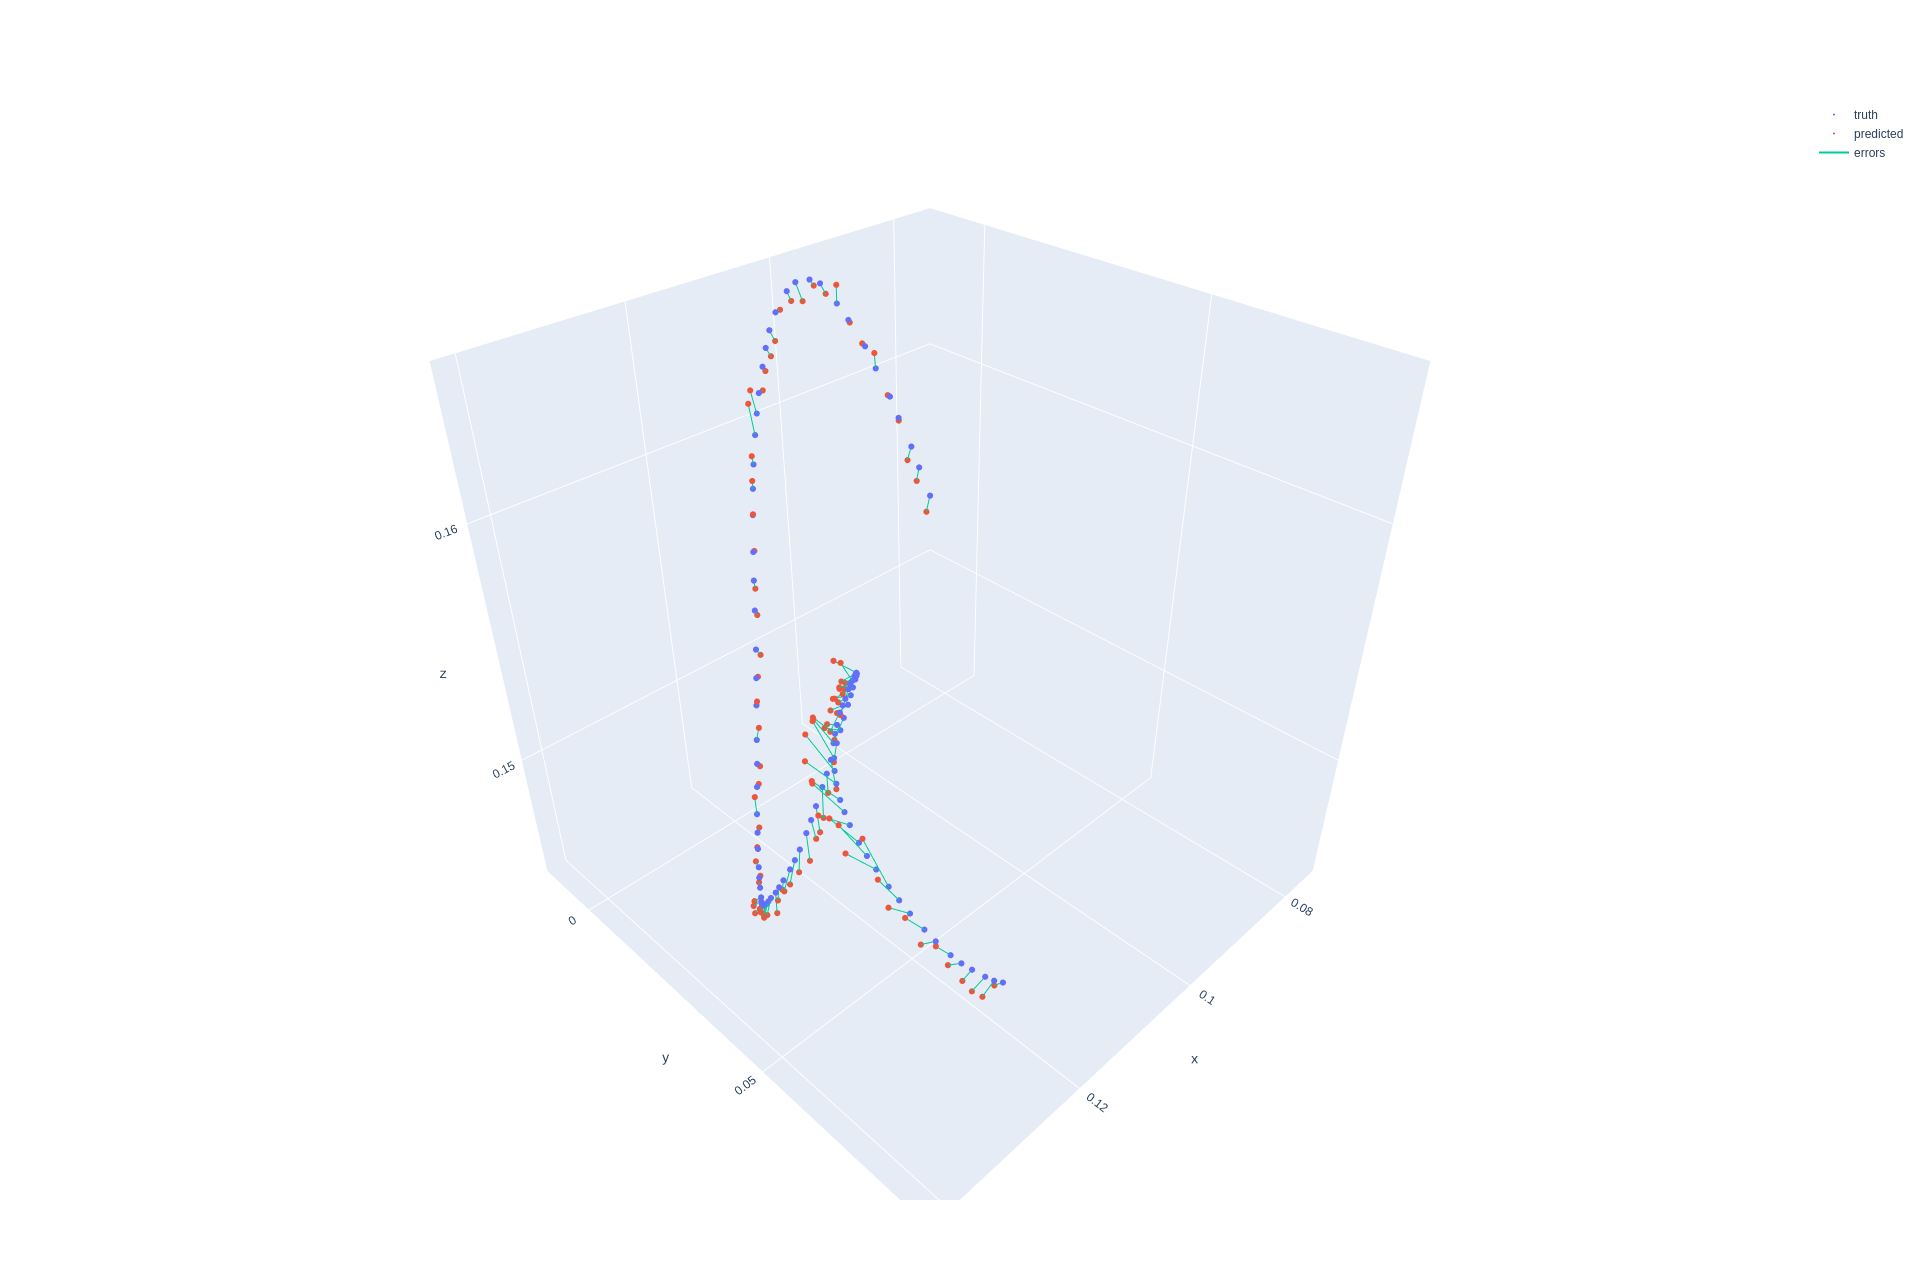

In [314]:
show_trajectories(np.array(gt_poses)[:, 3, :3], np.array(poses)[:, 3, :3])

In [72]:
poses[0]

array([[ 0.8735127 ,  0.48643783,  0.01880984,  0.        ],
       [ 0.34341863, -0.58838165, -0.73203176,  0.        ],
       [-0.3450206 ,  0.64589864, -0.6810106 ,  0.        ],
       [ 0.13191056,  0.08617777,  0.15277901,  1.        ]],
      dtype=float32)

In [73]:
gt_poses[0]

array([[ 0.8722986 ,  0.4882979 ,  0.02569568,  0.        ],
       [ 0.34789497, -0.58283824, -0.73434913,  0.        ],
       [-0.34360474,  0.64951116, -0.67828536,  0.        ],
       [ 1.3112    ,  0.8507    ,  1.5186    ,  1.        ]],
      dtype=float32)